In [1]:
# Compare voltage clamp and current clamp fits.
# Note that these .csv files loaded here have been process though "extract_first_pulse_fit_data_from_DB.py"
# "and catagorize_goodness_of_fit_by_eye.py"
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
font={'size':22}
matplotlib.rc('font', **font)

In [2]:
# load csv files.
i_df=pd.read_csv('/home/corinnet/workspace/aiephys/multipatch_analysis/analyses/ML_connected_iclamp_2018_12_18.csv')
v_df=pd.read_csv('/home/corinnet/workspace/aiephys/multipatch_analysis/analyses/ML_connected_vclamp_2018_12_12.csv')
i_df['uid']=i_df.apply(lambda row: "%.3f" % float(row.uid), axis=1)
v_df['uid']=v_df.apply(lambda row: "%.3f" % float(row.uid), axis=1)

# get rid of wacky Unnamed columns 
v_df=v_df[v_df.columns.drop(list(v_df.filter(regex='Unnamed')))]
i_df=i_df[i_df.columns.drop(list(i_df.filter(regex='Unnamed')))]

In [3]:
#Merge the any sign versus forced sign data frames
merged_df = pd.merge(i_df, v_df, on=['uid', 'pre_cell_id', 'post_cell_id', 
                                     'distance', 'acsf','post_cre', 'pre_cre',
                                    'boolean_connection', 'pre_layer', 'post_layer'], how='inner', suffixes={'_i', '_v'})
merged_df['uid']=merged_df['uid'].astype(str)

# note that the length of the merged data frame equaling the len of the smallest 
# individual dataframe shows that the values being merged on are the same in the
# two databases.
print(len(i_df))
print(len(v_df))
print(len(merged_df))

957
966
925


In [4]:
merged_df.keys()

Index([u'NRMSE_v', u'acsf', u'amp_v', u'boolean_connection', u'decay_tau_v',
       u'distance', u'latency_v', u'measured_amp_v', u'measured_baseline_v',
       u'n_sweeps_v', u'post_cell_id', u'post_cre', u'post_layer',
       u'pre_cell_id', u'pre_cre', u'pre_layer', u'rise_time_v',
       u'syn_excitation_v', u'uid', u'image_path_v', u'good_fit_v',
       u'data_clarity_v', u'NRMSE_i', u'amp_i', u'decay_tau_i', u'latency_i',
       u'measured_amp_i', u'measured_baseline_i', u'n_sweeps_i',
       u'rise_time_i', u'syn_excitation_i', u'image_path_i', u'good_fit_i',
       u'data_clarity_i'],
      dtype='object')

In [130]:
def basic_plots(df):
    
    sns.regplot('NRMSE_v', 'NRMSE_i', data=df, fit_reg=True)
    plt.show()
    sns.regplot('amp_v', 'amp_i', data=df, fit_reg=True)
    plt.show()
    sns.regplot('rise_time_v', 'rise_time_i', data=df, fit_reg=True)
    plt.show()
    sns.regplot('latency_v', 'latency_i', data=df, fit_reg=True)
    plt.show()
    sns.regplot('decay_tau_v', 'decay_tau_i', data=df, fit_reg=True)
    plt.show()
    
def cre_plots(df, plot_type):
    
    if plot_type=='cre':
        col_name=('pre_cre', 'post_cre')
        values=(('pvalb', 'pvalb', 'b'),
                ('rorb', 'rorb', 'r'),
                ('sim1', 'sim1', 'g'),
                ('tlx3','tlx3', 'm'),
                ('unknown', 'unknown', 'c'))
    elif plot_type=='layer':
        col_name=('pre_layer', 'post_layer')
        values=(('2', '2','b'),
               ('2/3', '2/3', 'r'),
               ('3', '3', 'g'),
               ('4', '4', 'm'),
               ('5', '5', 'c'),
               ('6', '6', 'y'))
    else:
        raise Exception()
    
    variables=(('NRMSE_v', 'NRMSE_i'),
               ('amp_v', 'amp_i'),
               ('rise_time_v', 'rise_time_i'),
               ('latency_v', 'latency_i'),
               ('decay_tau_v', 'decay_tau_i'))

               
               
    for var in variables:
        fs=15   

        plt.figure(figsize=(fs,fs))
        mod = smf.ols(formula='%s ~ %s' % (var[1], var[0]), data=df)
        res=mod.fit()
        sns.regplot(var[0], var[1], data=df, fit_reg=True, color ='k', 
                    label='all, n=%i, slope=%f, intercept=%.2E' % (len(df), res.params[var[0]], res.params.Intercept))
        for value in values: 
            plot_df=df[(df[col_name[0]]==value[0]) & (df[col_name[1]]==value[1])]
            mod = smf.ols(formula='%s ~ %s' % (var[1], var[0]), data=plot_df)
            res=mod.fit()
            sns.regplot(var[0], var[1], data=plot_df, fit_reg=True, color=value[2], 
                        label='%s to %s, n=%i, slope=%.2E, int=%.2E' % 
                        (value[0], value[1], len(plot_df), res.params[var[0]], res.params.Intercept))
        plt.xlim([np.min(df[var[0]]), np.max(df[var[0]])])
        plt.ylim([np.min(df[var[1]]), np.max(df[var[1]])])
        plt.legend()
        plt.show()
    

In [131]:
# look at data that is 'excellent'
excellent_df=merged_df[(merged_df['good_fit_i']=='excellent') & (merged_df['good_fit_v']=='excellent') & 
                      (merged_df['data_clarity_v']=='well') & (merged_df['data_clarity_i']=='well')]
#find combos that are common in this data set
#excellent_df.groupby(['pre_cre', 'post_cre']).size()
excellent_df[excellent_df['pre_layer']=='5']

,NRMSE_v,acsf,amp_v,boolean_connection,decay_tau_v,distance,latency_v,measured_amp_v,measured_baseline_v,n_sweeps_v,...,decay_tau_i,latency_i,measured_amp_i,measured_baseline_i,n_sweeps_i,rise_time_i,syn_excitation_i,image_path_i,good_fit_i,data_clarity_i
6,0.651624,1.3mM Ca & 1mM Mg,0.000311,True,0.017943,0.000082,0.002433,0.000325,-0.050412,39,...,0.003840,0.002384,-8.384469e-12,-3.036416e-11,14,0.003135,in,/home/corinnet/workspace/DBfit_pics/vclamp2018...,excellent,well
50,0.454087,1.3mM Ca & 1mM Mg,0.000256,True,0.020542,0.000612,0.002445,0.000256,-0.068787,45,...,0.008830,0.002596,-6.602734e-12,-4.722511e-11,34,0.001099,in,/home/corinnet/workspace/DBfit_pics/vclamp2018...,excellent,well
63,0.167329,1.3mM Ca & 1mM Mg,0.001027,True,0.500000,0.000161,0.001396,0.001056,-0.071525,37,...,0.010565,0.001351,-1.805301e-11,8.325392e-11,10,0.002376,in,/home/corinnet/workspace/DBfit_pics/vclamp2018...,excellent,well
67,0.194376,1.3mM Ca & 1mM Mg,0.000917,True,0.011419,0.000075,0.000908,0.000933,-0.069821,44,...,0.004059,0.001009,-3.015870e-11,3.146011e-11,44,0.001668,in,/home/corinnet/workspace/DBfit_pics/vclamp2018...,excellent,well
99,1.129553,2mM Ca & Mg,0.000154,True,0.015957,0.000066,0.001090,0.000146,-0.070071,41,...,0.004214,0.001125,-7.867244e-12,-2.253756e-11,5,0.001239,in,/home/corinnet/workspace/DBfit_pics/vclamp2018...,excellent,well
104,1.350986,2mM Ca & Mg,0.000265,True,0.499998,0.000060,0.001176,0.000149,-0.064694,33,...,0.003607,0.001128,-7.142657e-12,9.497110e-12,8,0.001156,in,/home/corinnet/workspace/DBfit_pics/vclamp2018...,excellent,well
138,0.448552,1.3mM Ca & 1mM Mg,0.000358,True,0.012691,0.000136,0.001610,0.000392,-0.070341,46,...,0.007695,0.001740,-7.187806e-12,-5.812273e-11,5,0.002130,in,/home/corinnet/workspace/DBfit_pics/vclamp2018...,excellent,well
186,0.293541,1.3mM Ca & 1mM Mg,-0.001866,True,0.062040,0.000066,0.000728,-0.001798,-0.053446,41,...,0.005082,0.000894,2.388273e-11,4.324907e-11,10,0.001481,ex,/home/corinnet/workspace/DBfit_pics/vclamp2018...,excellent,well
287,0.357336,2mM Ca & Mg,0.000520,True,0.014125,0.000073,0.001175,0.000495,-0.069270,75,...,0.001357,0.001209,-9.234518e-12,4.181513e-12,5,0.001062,in,/home/corinnet/workspace/DBfit_pics/vclamp2018...,excellent,well
288,1.469756,2mM Ca & Mg,0.000062,True,0.499999,0.000098,0.001921,0.000091,-0.069655,75,...,0.002451,0.001819,-7.173685e-12,1.225929e-11,5,0.001800,in,/home/corinnet/workspace/DBfit_pics/vclamp2018...,excellent,well


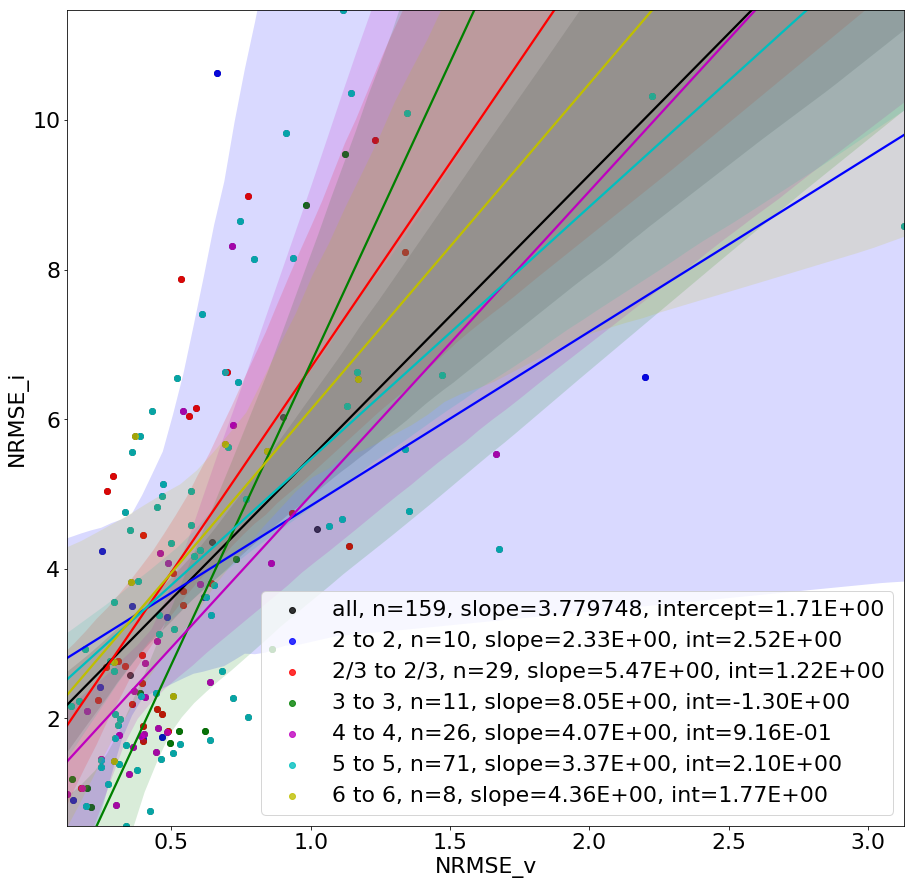

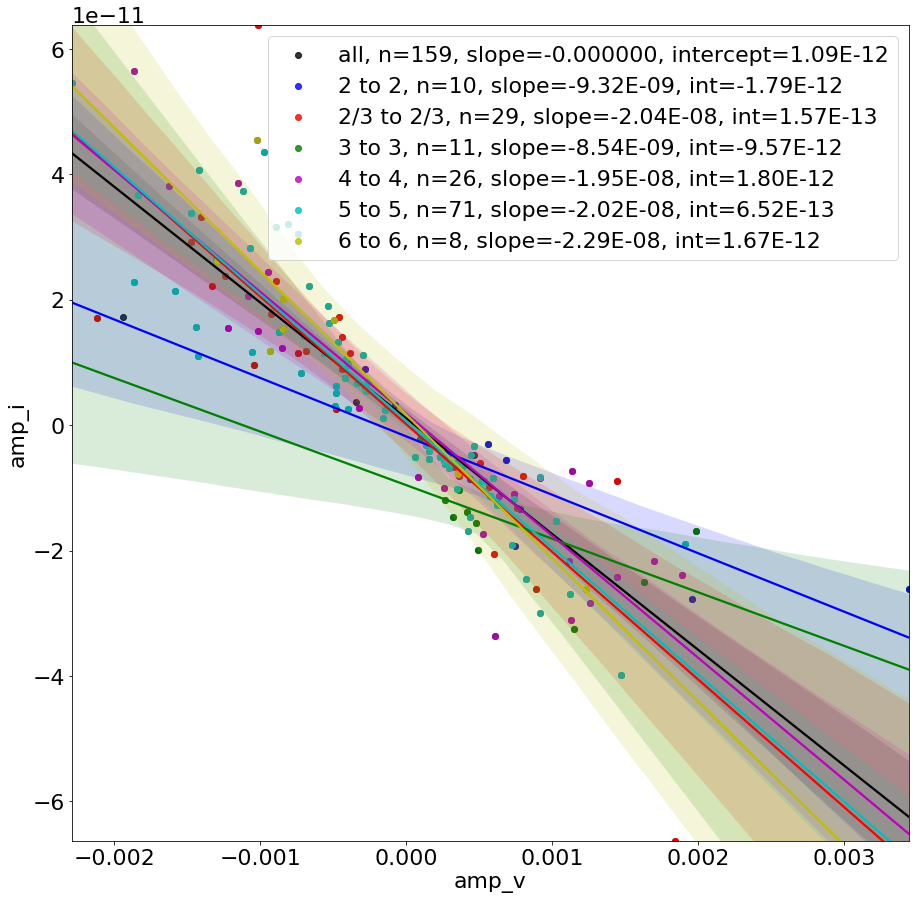

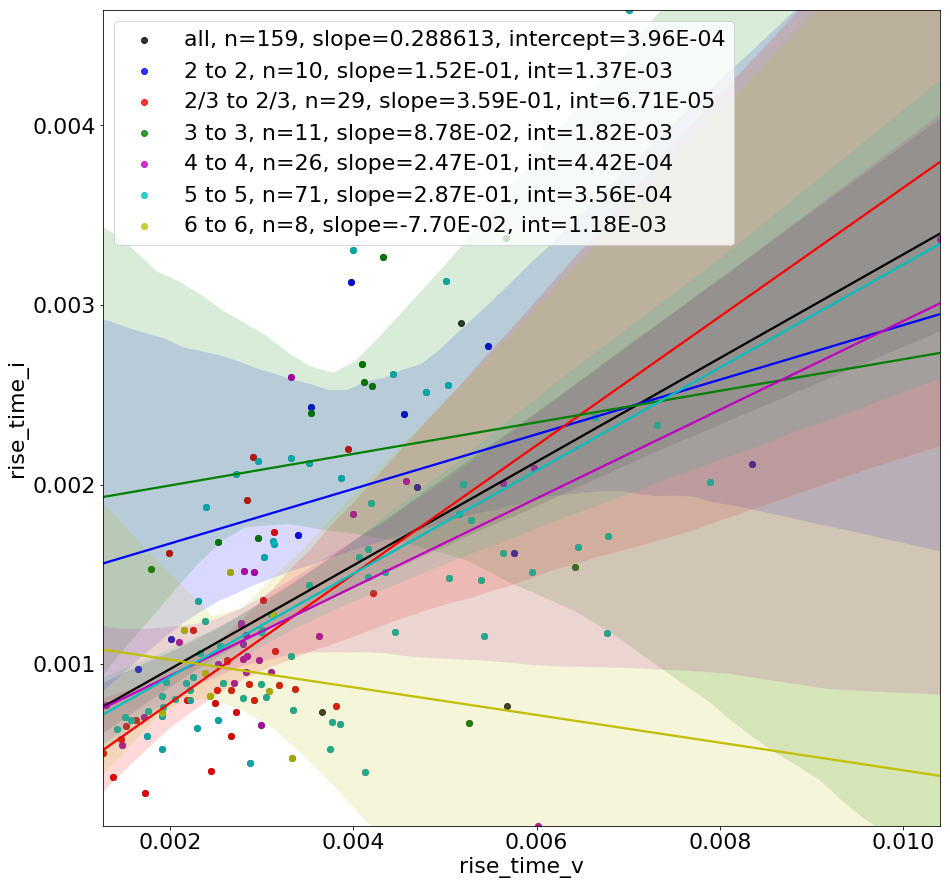

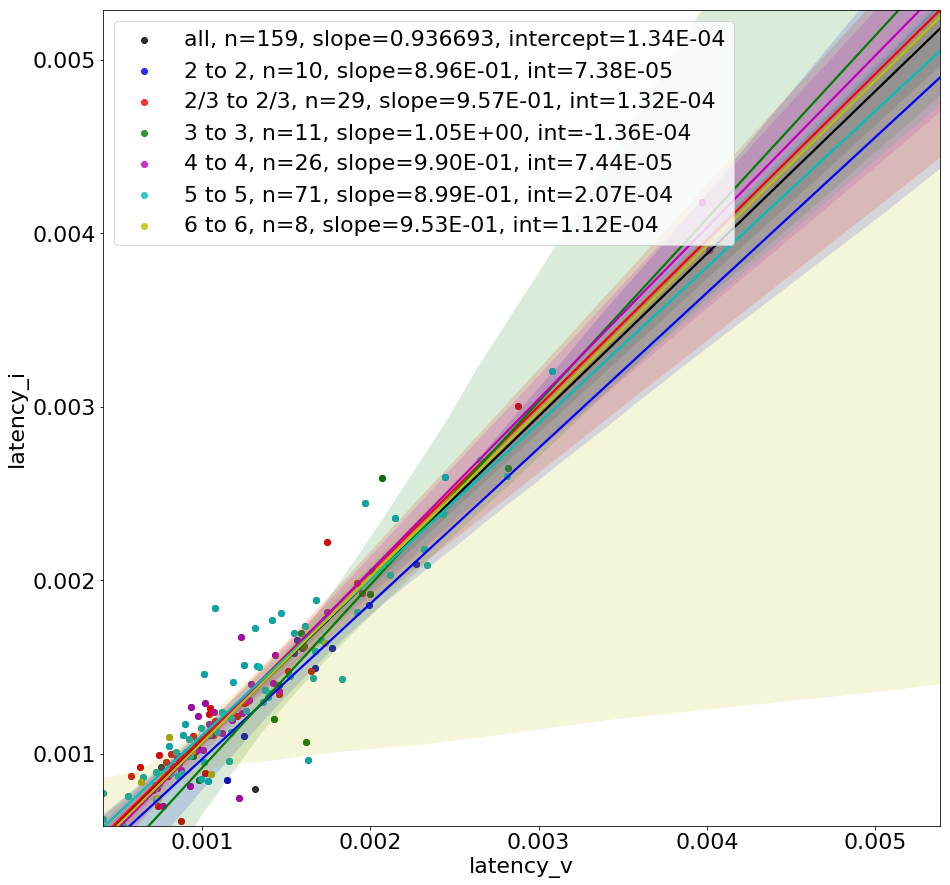

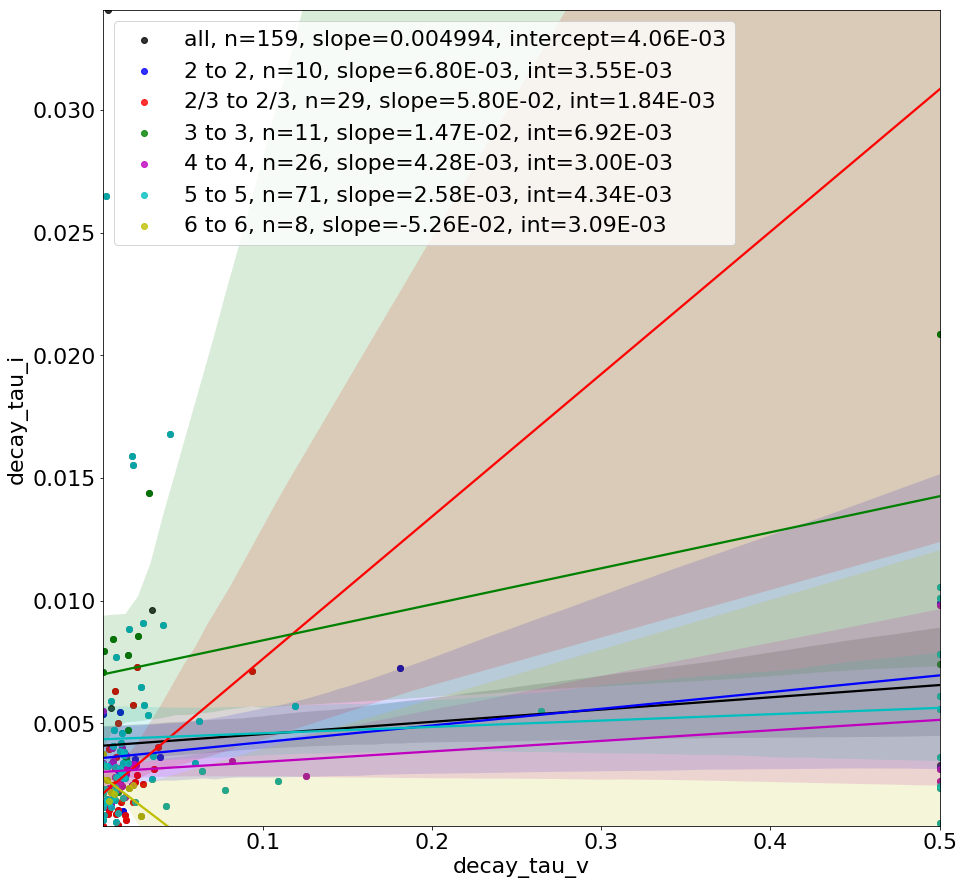

In [132]:
#plot all the data
matplotlib.rc('font', **font)
cre_plots(excellent_df, 'layer')

In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
mod = smf.ols(formula='NRMSE_i ~ NRMSE_v', data=excellent_df(excellent_df[col_name[0]]==value[0]) & (excellent_df[col_name[1]]==value[1]))
res =  mod.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                NRMSE_i   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     105.4
Date:                Thu, 20 Dec 2018   Prob (F-statistic):           3.10e-19
Time:                        12:52:40   Log-Likelihood:                -329.42
No. Observations:                 159   AIC:                             662.8
Df Residuals:                     157   BIC:                             669.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7081      0.268      6.383      0.000       1.180       2.237
NRMSE_v        3.7797      0.368     10.265      0.000       3.052       4.507
==============================================================================
Omnibus:                       16.347   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.098
Skew:                           0.787   Prob(JB):                     0.000118
Kurtosis:                       3.504   Cond. No.                         3.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
from IPython.display import Image, display 
import matplotlib.image as mpimg
for p in excellent_df[['image_path_i', 'image_path_v']].iterrows():
#    if type(p) is str:
    print (p[1].image_path_i)
    print (p[1].image_path_v)    
#     display(Image(filename=p[1].image_path_i, width=400, height=400))
#     display(Image(filename=p[1].image_path_v, width=400, height=400)) 
    f=plt.figure(figsize=(20,10))
    f.add_subplot(121)
    plt.imshow(mpimg.imread(p[1].image_path_i))
    plt.axis('off')
    f.add_subplot(122)
    plt.imshow(mpimg.imread(p[1].image_path_v)) 
    plt.axis('off')
    plt.show()
